**<center> <span style="color:crimson;font-family:serif; font-size:32px;"> NETFLIX MOVIES AND TV SHOWS EDA 📊</span> </center>**

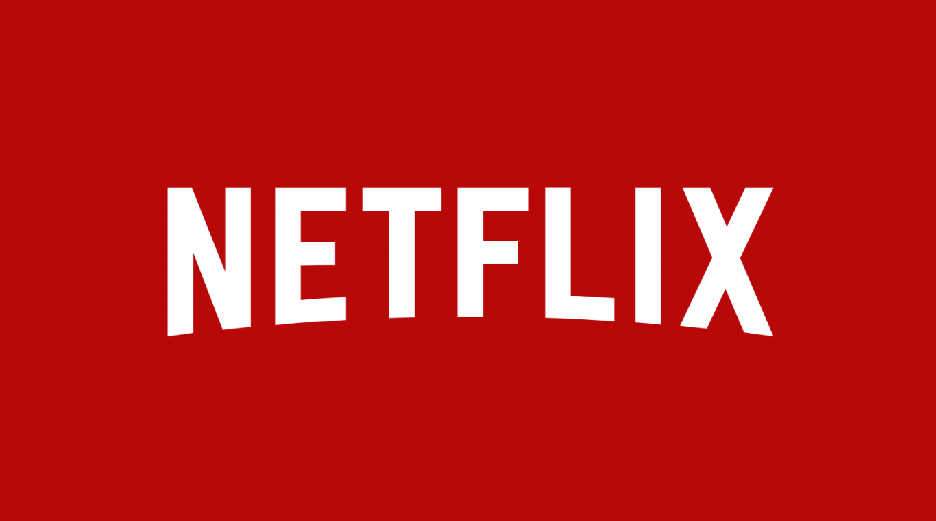

 <span style="color:crimson;font-family:serif; font-size:28px;"> Let's get started! </span>
 
This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# <span style="font-family:serif; font-size:28px;"> 1. Quick look at the data</span>

In [ ]:
#load data
main_df=pd.read_csv("../input/netflix-shows/netflix_titles.csv")
main_df.head()

In [ ]:
main_df.info()

The dataset has 7787 rows and 12 columns:
* show_id: unique id of each show (not much of a use for us in this notebook)
* type: The category of a show, can be either a Movie or a TV Show
* title: Name of the show
* director: Name of the director(s) of the show
* cast: Name of actors and other cast of the show
* country: Name of countries the show is available to watch on Netflix
* date_added: Date when the show was added on Netflix
* release_year: Release year of the show
* rating: Show rating on netflix
* duration: Time duration of the show
* listed_in: Genre of the show
* description: Some text describing the show

# <span style="font-family:serif; font-size:28px;"> 2. Visualize missing values </span>


In [ ]:
# Visualize missing values as a matrix
msno.matrix(main_df);


> **Using this matrix you can very quickly find the pattern of missingness in the dataset.
From the above visualisation we can observe that "director" has a peculiar pattern that stands out."cast" and "country" have a similar pattern of missing values while column "date_added" shows a different pattern.**


In [ ]:
# Visualize the number of missing values as a bar chart
msno.bar(main_df);

> **This bar chart gives you an idea about how many missing values are there in each column.
> "director" has the most missing value followed by "cast" and "country". There are few missing value in "date_added" and "rating".**



In [ ]:
# Visualize the correlation between the number of missing values in different columns as a heatmap
msno.heatmap(main_df);

> **Heatmap shows the correlation of missingness between every 2 columns. A value near 0 means there is no dependence between the occurrence of missing values of two variables.**

In [ ]:
for i in main_df.columns:
    null_rate = main_df[i].isna().sum() / len(main_df) * 100 
    if null_rate > 0 :
        print("{}'s null rate :{}%".format(i,round(null_rate,2)))

# <span style="font-family:serif; font-size:28px;"> 3. Data Cleaning </span>


**Lets check how many nulls are there in the data** 

In [ ]:
#number of unique elements
main_df.nunique()

In [ ]:
#Detect missing values
main_df.isna().sum()

**The missing values are in:**

* "director": Very less information-not needed for the analysis so I will be dropping this 
* "cast": there are too many diferent values so I will be dropping this 
* "country":Important variable hence we need to fix this
* "date_added": there are just a few cases, so lets scrap them
* "rating": there are just a few cases, so lets scrap them  

### Let's fix the missing "rating"

In [ ]:
main_df["rating"].unique()

In [ ]:
main_df[main_df["rating"].isna()]

Since there are only 7 rows so I decided to find there replacements from internet.

In [ ]:
 rating_replacements = {
    67: 'TV-PG',
    2359: 'TV-14',
    3660: 'TV-MA',
    3736: 'TV-MA',
    3737: 'NR',
    3738: 'TV-MA',
    4323: 'TV-MA '
}

for id, rate in rating_replacements.items():
    main_df.iloc[id, 8] = rate
    
main_df['rating'].isna().sum()

### Drop "director" and "cast" columns

In [ ]:
main_df = main_df.drop(['director', 'cast'], axis=1)
main_df.columns

### Fix "date_added" column

In [ ]:
main_df[main_df['date_added'].isna()]

Since it is difficult to find the date_added so I will drop these as they are only 10 rows.

In [ ]:
main_df=main_df[main_df["date_added"].notna()]

### Fix "country" missing values

In [ ]:
main_df['country'] = main_df['country'].fillna(main_df['country'].mode()[0])

There are some entry where "country" has multiple values. so i think i will add a new column with just the first one so we can check witch regions have more productions

In [ ]:
# Lets retrieve just the first country
main_df['principal_country'] = main_df['country'].apply(lambda x: x.split(",")[0])
main_df['principal_country'].head()

### Let's check the clean data

In [ ]:
main_df.isna().sum()

In [ ]:
main_df.dtypes

### Let's Generate new columns based on variables
#### Year and month 

In [ ]:
main_df['year_added'] = main_df['date_added'].apply(lambda x: x.split(" ")[-1])
main_df['year_added'].head()

In [ ]:
main_df['month_added'] = main_df['date_added'].apply(lambda x: x.split(" ")[0])
main_df['month_added'].head()

#### Targets based on "rating"

In [ ]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

main_df['target_ages'] = main_df['rating'].replace(ratings_ages)
main_df['target_ages'].unique()

### Let's fix the datatype 

In [ ]:
# type should be a category
main_df['type'] = pd.Categorical(main_df['type'])

# target_ages is another category (4 classes)
main_df['target_ages'] = pd.Categorical(main_df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# Year added should be integer so we can compare with `released_year`
main_df['year_added'] = pd.to_numeric(main_df['year_added'])

In [ ]:
main_df.dtypes

# <span style="font-family:serif; font-size:28px;"> 4. Data Visualization </span>

In [ ]:
plt.figure(figsize=(14, 7))
labels=['TV Show', 'Movie']
plt.pie(main_df['type'].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['lightblue','royalblue'], startangle=90)
plt.title('Type of Netflix Content')
plt.axis('equal')
plt.show()

>  Nearly 2/3rd of the content on netflix are movies while the rest are TV Show

In [ ]:
df_tv = main_df[main_df["type"] == "TV Show"]
df_movies = main_df[main_df["type"] == "Movie"]

In [ ]:
movie_ratings = df_movies.groupby(['rating'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)  
sns.pointplot(x='rating',y='count',data=movie_ratings)
plt.title('Top Movie Ratings Based On Rating System',size='20')
plt.show()

In [ ]:
tv_ratings = df_tv.groupby(['rating'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)  
sns.pointplot(x='rating',y='count',data=tv_ratings)
plt.title('Top TV Show Ratings Based On Rating System',size='20')
plt.show()

In [ ]:
def generate_rating_df(main_df):
    rating_df = main_df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts']
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

In [ ]:
rating_df = generate_rating_df(main_df)
fig = px.bar(rating_df, x='rating', y='counts', color='target_ages', title='Ratings of Movies And TV Shows Based On Target Age Groups',  labels={'counts':'COUNT', 'rating':'RATINGS', 'target_ages':'TARGET AGE GROUPS' })
fig.show()

In [ ]:
rating_order_movie =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']
rating_order_tv =  [ 'TV-Y', 'TV-G', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'TV-14', 'R', 'TV-MA']
movie_rating = df_movies['rating'].value_counts()[rating_order_movie]
tv_rating = df_tv['rating'].value_counts()[rating_order_tv].fillna(0)
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(15, 7))
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#d0d0d0", width=0.6, edgecolor='black')

    color =  ['green',  'blue',  'orange',  'red']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.1)

    ax.set_title(f'Distribution of {title} Rating', fontsize=20, fontweight='bold', position=(0.5, 1.0+0.03))
    plt.show()

In [ ]:
rating_barplot(movie_rating,'Movie', 1500)

> There's less movies for the kids while more for teens and adults.

In [ ]:
rating_barplot(tv_rating,'TV Show' , 600, 1500)

> TV Show are more for the kids and teens.

I learnt the above visualization from @subinium , reference to his <a href="https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips"> notebook </a>

In [ ]:
df_content = main_df['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_content['percent'] = df_content['count'].apply(lambda x : 100*x/sum(df_content['count']))


df_tv1 = df_tv['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_tv1['percent'] = df_tv1['count'].apply(lambda x : 100*x/sum(df_tv1['count']))


df_movies1 = df_movies['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_movies1['percent'] = df_movies1['count'].apply(lambda x : 100*x/sum(df_movies1['count']))

t1 = go.Scatter(x=df_movies1['year_added'], y=df_movies1["count"], name="Movies", marker=dict(color="royalblue"))
t2 = go.Scatter(x=df_tv1['year_added'], y=df_tv1["count"], name="TV Shows", marker=dict(color="red"))
t3 = go.Scatter(x=df_content['year_added'], y=df_content["count"], name="Total Contents", marker=dict(color="gold"))

data = [t1, t2, t3]

layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

* The growth in number of movies on netflix is much higher than that of TV shows
* About 1200 new movies were added in both 2018 and 2019
* The growth in content started from 2013

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=df_movies, palette="coolwarm", order=df_movies['release_year'].value_counts().index[0:15])

plt.title('ANALYSIS ON RELEASE YEAR OF MOVIES', fontsize=15, fontweight='bold')
plt.show()

> Most of the movies were released in the year 2017 followed by 2018 and 2016.

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=df_tv, palette="coolwarm", order=df_tv['release_year'].value_counts().index[0:15])

plt.title('ANALYSIS ON RELEASE YEAR OF TV Show', fontsize=15, fontweight='bold')
plt.show()

> Most of the TV Shows were released in 2020 followed by 2019 and 2018

## Distribution of Movie duration

In [ ]:
from scipy.stats import norm

plt.figure(figsize=(15,7))
sns.distplot(df_movies['duration'].str.extract('(\d+)'),fit=norm,kde=False, color=['red'])
plt.title('Distplot with Normal distribution for Movies',fontweight="bold")
plt.show()

> It is evident that majority of the movies have duration ranging from 85 min to 120 min.

In [ ]:
fig = px.histogram(x=df_tv['duration'])
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Distribution of TV Shows duration",
    xaxis_title="Duration of TV ShowS",
)
fig.show()

> We can say that mostTV Shows end by season 3

## Top10 Genre in Movies and TV Shows:

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x = df_movies["listed_in"].value_counts().head(10).index,
            y = df_movies["listed_in"].value_counts().head(10).values,palette="pink")
plt.xticks(rotation=60)
plt.title("Top10 Genre in Movies",fontweight="bold")
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x = df_tv["listed_in"].value_counts().head(10).index,
            y = df_tv["listed_in"].value_counts().head(10).values,palette="vlag")
plt.xticks(rotation=70)
plt.title("Top10 Genre in TV Shows",fontweight="bold")
plt.show()

## Top-20 countries producing most contents:

In [ ]:
from collections import Counter
country_data = main_df['country']
country_count = pd.Series(dict(Counter(','.join(country_data).replace(' ,',',').replace(
    ', ',',').split(',')))).sort_values(ascending=False)
top20country = country_count.head(20)

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x= top20country.index, y=top20country, palette="pastel")
plt.xticks(rotation=50)
plt.title('Top 20 countries with most contents', fontsize=15, fontweight='bold')
plt.show()

## World Cloud-Movie Genre

In [ ]:
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(df_movies['listed_in'])

plt.rcParams['figure.figsize'] = (12,12)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## World Cloud-TV Show Genre

In [ ]:
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(df_tv['listed_in'])

plt.rcParams['figure.figsize'] = (12,12)
wordcloud = WordCloud(background_color = 'black',colormap='vlag', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

 <span style="color:crimson;font-family:serif; font-size:20px;">  Please upvote if you liked the kernel! 😀
    <p style="color:royalblue;font-family:serif; font-size:20px;">KEEP KAGGLING!</p> 
</span>